<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/Pretrainedpremademodel_2fE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image
import random
import os
import csv
import shutil
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import os
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
drive.mount('/content/drive')
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
# DATA LOADING

root_directory = "/content/drive/My Drive/PokemonData"
selected_subdirectory = "/content/drive/My Drive/SelectedPokemonData"

# Get a list of all folders in the PokemonData directory
all_folders = [f for f in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, f))]

# Select random folders
n = 10
selected_folders = random.sample(all_folders, n)
print(selected_folders)

# Remove and recreate selected subdirectory
shutil.rmtree(selected_subdirectory, ignore_errors=True)
os.makedirs(selected_subdirectory, exist_ok=True)

# Copy selected folders to the subdirectory
for folder_name in selected_folders:
    src_folder_path = os.path.join(root_directory, folder_name)
    dest_folder_path = os.path.join(selected_subdirectory, folder_name)
    shutil.copytree(src_folder_path, dest_folder_path)

# Define a common size for resizing images
common_size = (224, 224)

# Dictionary to store image arrays for selected folders
image_arrays_dict = {}

# Iterate over the selected folders in the subdirectory
for folder_name in selected_folders:
    folder_path = os.path.join(selected_subdirectory, folder_name)
    image_arrays = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".png")):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path).convert("RGB").resize(common_size, Image.ANTIALIAS)
            img_array = np.array(img)
            image_arrays.append(img_array)
    image_arrays_dict[folder_name] = np.array(image_arrays)

# Combine all image arrays into a single array
all_images = np.concatenate(list(image_arrays_dict.values()), axis=0)

# Display selected classes and number of images per class
pokemon_classes = list(image_arrays_dict.keys())
num_images_per_class = [len(images) for images in image_arrays_dict.values()]
print(pokemon_classes)
print(num_images_per_class)

['Venomoth', 'Ditto', 'Scyther', 'Krabby', 'Nidoran-f', 'Diglett', 'Mankey', 'Jigglypuff', 'Persian', 'Ekans']


<ipython-input-93-d2e834dd3152>:37: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



['Venomoth', 'Ditto', 'Scyther', 'Krabby', 'Nidoran-f', 'Diglett', 'Mankey', 'Jigglypuff', 'Persian', 'Ekans']
[119, 107, 146, 141, 66, 137, 164, 135, 114, 86]


In [94]:
# AUGMENTATION

transform = v2.Compose([
    v2.ToImage(),
    #v2.RandomHorizontalFlip(p=1),
    v2.RandomGrayscale(p=1),
    v2.ToDtype(torch.float32, scale=True)
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_images = []
for img in all_images:
  aug_image = transform(img)
  aug_images.append(aug_image)

aug_images = torch.stack(aug_images)
#combined_images = np.concatenate([all_images, aug_images.permute(0, 2, 3, 1)], axis=0)
combined_images = np.array(aug_images.permute(0, 2, 3, 1))

all_labels = np.concatenate([np.full(num, i) for i, num in enumerate(num_images_per_class)])
combined_labels = np.concatenate([all_labels])


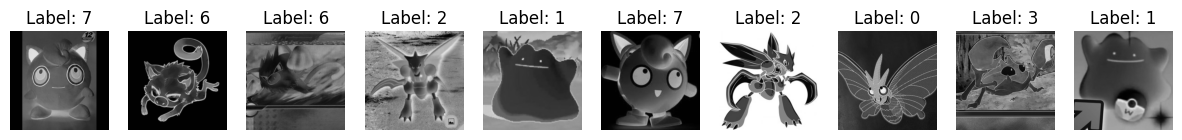

In [95]:
# SHOWING AUGMENTATION

num_samples = 10  # You can adjust this number as needed
random_indices = random.sample(range(len(combined_images)), num_samples)

# Plot images with labels
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image = combined_images[idx]
    label = combined_labels[idx]
    np_image = (image.squeeze() * 255).astype(np.uint8)
    np_image = 255 - np_image
    axes[i].imshow(np_image)
    axes[i].set_title("Label: {}".format(label))
    axes[i].axis('off')

plt.show()

In [96]:
# OUR CUSTOM MODEL

combined_images = all_images
combined_labels = all_labels

# Split dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=2, stratify=combined_labels
)
#split test into validation and test
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=2, stratify=test_labels
)
# Convert NumPy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# Define the number of classes and input channels
num_classes = n
num_input_channels = 3

# Define the model architecture


In [97]:
# MOBILENETV2 MODEL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.mobilenet_v2(weights=None)

# Modify the fully connected layer to match the number of classes dataset
num_classes = len(pokemon_classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move the model to the appropriate device
model = model.to(device)

In [98]:
# # LOADING A SAVED MODEL

# # Load the saved model weights
# saved_model_path = "/content/drive/My Drive/updated_mobilenetv2.pth"
# checkpoint = torch.load(saved_model_path)

# model.load_state_dict(checkpoint['model_state_dict'])

In [99]:
# TRAINING AND TESTING THE MODEL
model = nn.Sequential(
    nn.Conv2d(num_input_channels, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(0.),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

# Move model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_loss_list1 = []
val_accuracy_list1 = []
y_true1 = []
y_pred1 = []
val_f1_list1 = []
# Train the model
def train():
    model.train()
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images.permute(0, 3, 1, 2))

        # Compute the loss
        loss = criterion(logits, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_list1.append(loss.item())
# Define testing function
def validate(epoch):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images.permute(0, 3, 1, 2))

            # Compute total correct so far
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            y_true1.extend(labels.cpu().numpy())
            y_pred1.extend(predicted.cpu().numpy())
            accuracy = 100 * correct / total
            f1 = f1_score(y_true1, y_pred1, average='macro')
        val_f1_list1.append(f1)
        val_accuracy_list1.append(accuracy)

        print(f'validation accuracy after {epoch+1} epochs: {accuracy:.2f}%')
        #print(f'F1 score after {epoch+1} epochs: {f1:.2f}')
        scheduler.step(accuracy)

num_epochs = 20
for epoch in range(num_epochs):
    train()
    validate(epoch)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



validation accuracy after 1 epochs: 46.28%
validation accuracy after 2 epochs: 74.38%
validation accuracy after 3 epochs: 78.51%
validation accuracy after 4 epochs: 80.17%
validation accuracy after 5 epochs: 84.30%
validation accuracy after 6 epochs: 86.78%
validation accuracy after 7 epochs: 86.78%
validation accuracy after 8 epochs: 88.43%
validation accuracy after 9 epochs: 89.26%
validation accuracy after 10 epochs: 89.26%
validation accuracy after 11 epochs: 89.26%
validation accuracy after 12 epochs: 90.08%
validation accuracy after 13 epochs: 90.08%
validation accuracy after 14 epochs: 90.08%
validation accuracy after 15 epochs: 90.08%
validation accuracy after 16 epochs: 90.08%
validation accuracy after 17 epochs: 90.08%
validation accuracy after 18 epochs: 90.08%
validation accuracy after 19 epochs: 90.08%
validation accuracy after 20 epochs: 90.91%


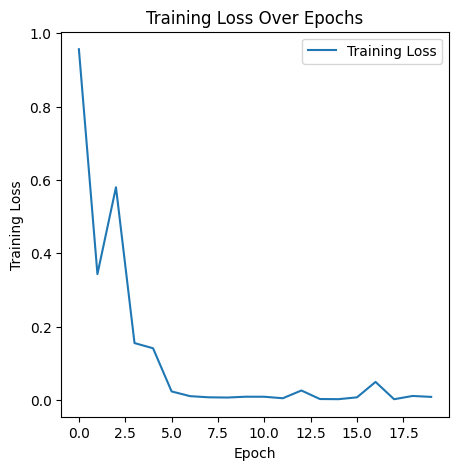

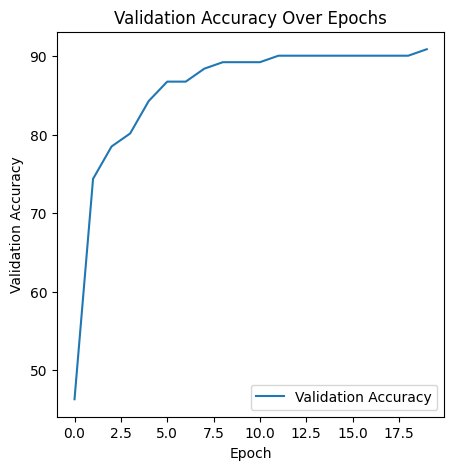

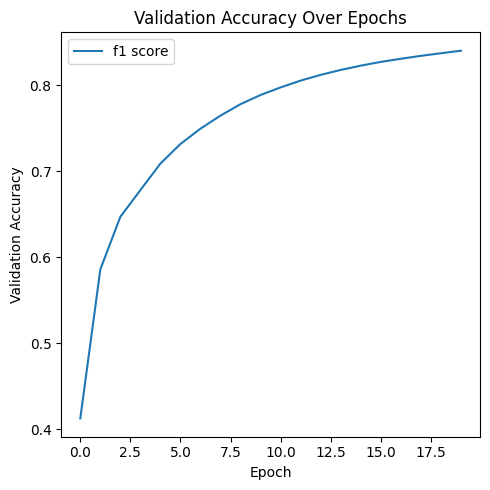

In [100]:
# Plot the training loss and test accuracy graph after all epochs
plt.figure(figsize=(5, 5))

plt.plot(train_loss_list1, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.figure(figsize=(5, 5))
plt.plot(val_accuracy_list1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(5, 5))
plt.plot(val_f1_list1, label='f1 score')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
def test():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images.permute(0, 3, 1, 2))

            # Compute total correct so far
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
        print(f'test accuracy {100 * correct / total:.2f}%')
        scheduler.step(accuracy)

test()

test accuracy 87.70%


In [102]:
# MOBILENETV2 MODEL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.mobilenet_v2(weights=None)

# Modify the fully connected layer to match the number of classes dataset
num_classes = len(pokemon_classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move the model to the appropriate device
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_loss_list2 = []
val_accuracy_list2 = []
y_true2 = []
y_pred2 = []
val_f1_list2 = []
# Train the model
def train():
    model.train()
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images.permute(0, 3, 1, 2))

        # Compute the loss
        loss = criterion(logits, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_list2.append(loss.item())
# Define testing function
def validate(epoch):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images.permute(0, 3, 1, 2))

            # Compute total correct so far
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            y_true2.extend(labels.cpu().numpy())
            y_pred2.extend(predicted.cpu().numpy())
            accuracy = 100 * correct / total
            f1 = f1_score(y_true2, y_pred2, average='macro')
        val_accuracy_list2.append(accuracy)
        val_f1_list2.append(f1)
        print(f'validation accuracy after {epoch+1} epochs: {accuracy:.2f}%')
        #print(f'F1 score after {epoch+1} epochs: {f1:.2f}')
        scheduler.step(accuracy)

num_epochs = 20
for epoch in range(num_epochs):
    train()
    validate(epoch)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



validation accuracy after 1 epochs: 11.57%
validation accuracy after 2 epochs: 11.57%
validation accuracy after 3 epochs: 41.32%
validation accuracy after 4 epochs: 46.28%
validation accuracy after 5 epochs: 68.60%
validation accuracy after 6 epochs: 77.69%
validation accuracy after 7 epochs: 74.38%
validation accuracy after 8 epochs: 79.34%
validation accuracy after 9 epochs: 75.21%
validation accuracy after 10 epochs: 81.82%
validation accuracy after 11 epochs: 80.17%
validation accuracy after 12 epochs: 86.78%
validation accuracy after 13 epochs: 81.82%
validation accuracy after 14 epochs: 84.30%
validation accuracy after 15 epochs: 83.47%
validation accuracy after 16 epochs: 83.47%
validation accuracy after 17 epochs: 83.47%
validation accuracy after 18 epochs: 84.30%
validation accuracy after 19 epochs: 81.82%
validation accuracy after 20 epochs: 82.64%


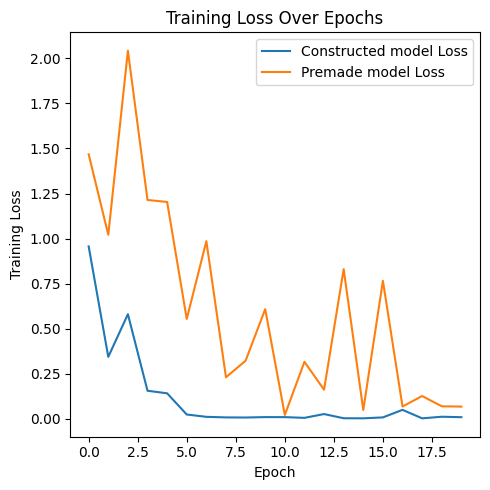

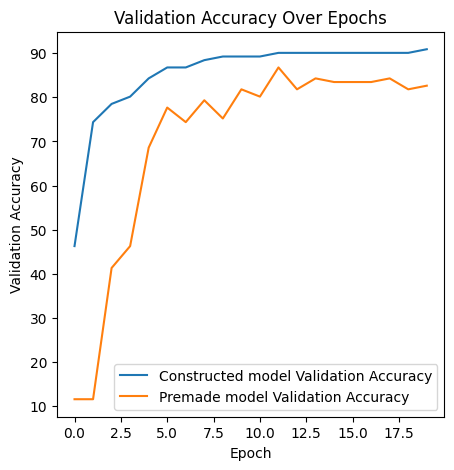

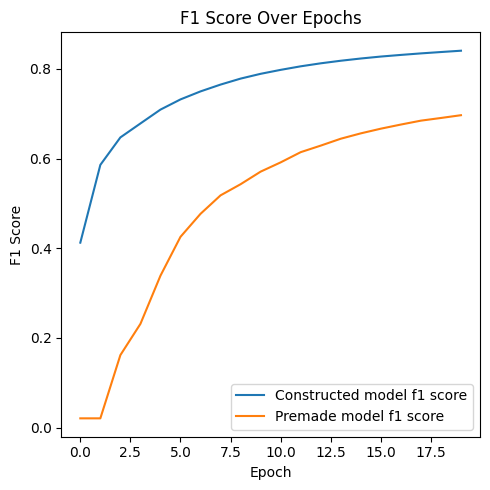

In [103]:
#plot both val and loss of the different models
plt.figure(figsize=(5, 5))

plt.plot(train_loss_list1, label='Constructed model Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')

plt.plot(train_loss_list2, label='Premade model Loss')  # Assuming val_loss_list contains validation loss values
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(val_accuracy_list1, label='Constructed model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.plot(val_accuracy_list2, label='Premade model Validation Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(5, 5))
plt.plot(val_f1_list1, label='Constructed model f1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.plot(val_f1_list2, label='Premade model f1 score')
plt.legend()


plt.tight_layout()
plt.show()

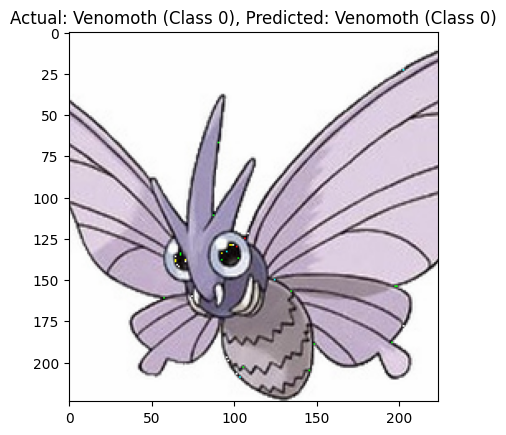

['Ditto', 'Diglett', 'Jigglypuff', 'Nidoran-f', 'Mankey', 'Persian', 'Ekans', 'Krabby', 'Scyther', 'Venomoth']


Venomoth : 71.38616442680359 %


In [133]:
import seaborn as sns
import plotly.graph_objects as go

def display_random_image_prediction2(num_runs):
    predicted_probs_list = []

    index_to_display = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[index_to_display]
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(image.permute(0, 3, 1, 2))
        mean_probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()
        #predicted_probs_list.append(predicted_probs)

    predicted_label = torch.argmax(logits).item()
    np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
    np_image = 255 - np_image

    # Display the image
    plt.imshow(np_image)
    plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
    plt.show()

    # Display the predicted probabilities for each class after all runs
    #mean_probs = np.mean(predicted_probs_list, axis=0)
    sorted_data = sorted(zip(pokemon_classes, mean_probs), key=lambda x: x[1], reverse=False)

    # Unzip the sorted data
    pokemon_classes_sorted, mean_probs_sorted = zip(*sorted_data)
    pokemon_classes_sorted = list(pokemon_classes_sorted)
    print(pokemon_classes_sorted)

    text_probs = [str('{0:.2f}'.format(100*val)) if val >= 0.01 else '' for val in mean_probs]
    # sns.barplot(x=mean_probs, y=pokemon_classes, order=pokemon_classes)
    # plt.barh(pokemon_classes_sorted, mean_probs_sorted)
    fig = go.Figure(go.Bar(
    y=pokemon_classes,
    x=100*mean_probs,
    orientation='h',
    text=text_probs,  # Set the text attribute to display the values on the bars
    textposition='auto'
    ))

    # Update layout to display bars in descending order of values
    fig.update_layout(title='Predicted Percentages for Each Class',
                      yaxis=dict(autorange="reversed"),  # Reverse the y-axis to display bars from top to bottom
                      xaxis_title='Mean Percentages',
                      yaxis_title='Classes',
                      width=400,  # Adjust the width of the graph
                      height=400)

    # Show the plot
    fig.show()

    print(pokemon_classes[label],':', 100*mean_probs[label],'%')
display_random_image_prediction2(1)

In [105]:
# SAVING A MODEL

torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': num_classes,
    'class_labels': pokemon_classes,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}, '/content/drive/My Drive/updated_mobilenetv2.pth')

# for saving the model and checking it exists in dierectory
# mean and std are standard found previously to be best for normalising RGB

files = os.listdir('/content/drive/My Drive')

# Check if the saved model file exists
if 'updated_mobilenetv2.pth' in files:
    print("The model checkpoint file exists in the current directory.")
else:
    print("The model checkpoint file does not exist in the current directory.")
print("New Model saved successfully!")


The model checkpoint file exists in the current directory.
New Model saved successfully!


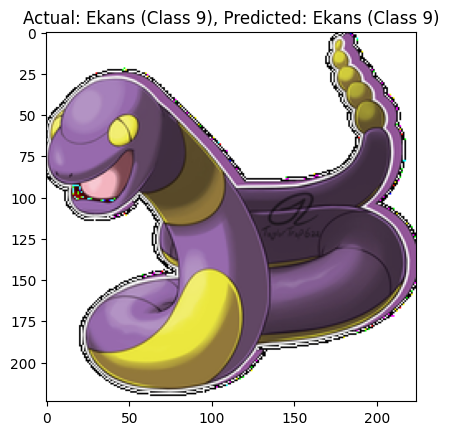

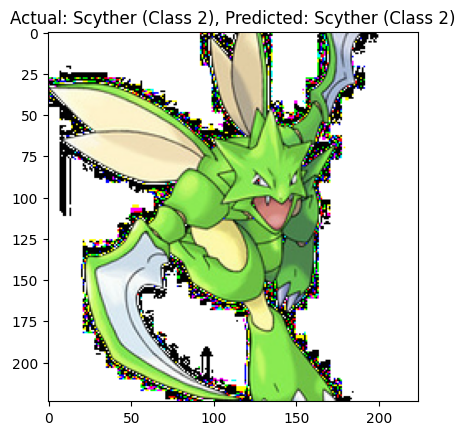

In [106]:
# SHOWING MODEL PREDICITONS

def display_random_image_prediction(num_runs):
  for i in range(1,num_runs):
    index_to_display = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[index_to_display]
    image = image.unsqueeze(0).to(device)
    logits = model(image.permute(0, 3, 1, 2))
    predicted_label = torch.argmax(logits).item()
    np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
    np_image = 255 - np_image
    plt.imshow(np_image)
    plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
    plt.show()

display_random_image_prediction(3)


In [107]:
image_path = '/content/drive/My Drive/Clefairy3.jpg'

image = Image.open(image_path).convert("RGB")  # Convert to RGB format
image_resized = image.resize((common_size[1], common_size[0]), Image.ANTIALIAS)
image_array = np.array(image_resized)
image = torch.tensor(image_array, dtype = torch.float32)
plt.imshow(image_array)
plt.show()
label = 10

image = image.unsqueeze(0).to(device)
logits = model(image.permute(0, 3, 1, 2))
predicted_label = torch.argmax(logits).item()
np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
np_image = 255 - np_image
plt.imshow(np_image)
plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Clefairy3.jpg'